In [275]:
from dataclasses import dataclass
from random import choice, sample
from statistics import mean
from time import perf_counter
from typing import Callable

import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import seaborn as sns

plt.rcParams['figure.figsize'] = (16, 12)
sns.set_theme(style="darkgrid")


In [276]:
df_a = pd.read_csv("data/TSPA.csv", sep=";", header=None, names=["x", "y", "cost"])
df_b = pd.read_csv("data/TSPB.csv", sep=";", header=None, names=["x", "y", "cost"])


In [277]:
df_a

,x,y,cost
0,1510,353,84
1,3042,123,483
2,2145,389,1462
3,1030,365,1986
4,2125,360,145
...,...,...,...
195,1023,1258,197
196,3192,1271,1183
197,3735,1879,1461
198,3983,299,1309


In [278]:
df_b

,x,y,cost
0,2907,1115,928
1,3433,183,1864
2,2237,74,260
3,91,583,1006
4,3053,1867,993
...,...,...,...
195,1252,970,1882
196,613,784,439
197,3139,470,597
198,2465,1165,570


# Problem:
 1. Select 50% of nodes and form a Hamiltonian cycle.
 2. The sum of the total length of the path plus the total cost of the selected nodes should be minimized.

In [279]:
@dataclass
class Node:
    def __init__(self, id, x, y, cost) -> None:
        self.id = id
        self.x = x
        self.y = y
        self.cost = cost

    def __eq__(self, o: object) -> bool:
        if isinstance(o, Node):
            return self.id == o.id

        return False
    
    def __hash__(self) -> int:
        return self.id

    def __repr__(self) -> str:
        return (
            f"\n{' Node ':=^80}"
            f"\n{'id:':<40}{self.id}"
            f"\n{'x:':<40}{self.x}"
            f"\n{'y:':<40}{self.y}"
            f"\n{'cost:':<40}{self.cost}"
            f"\n{'':=^80}\n"
        )

    def __str__(self) -> str:
        return str(self.id)



In [280]:
nodes = [Node(i, x, y, cost) for i, (x, y, cost) in enumerate(zip(df_a.x, df_a.y, df_a.cost))]

In [281]:
# Check if the nodes are unique
len(set(nodes)) == len(nodes)

True

In [282]:
def _euclidean_distance(a: Node, b: Node) -> float:
    return round(((a.x - b.x) ** 2 + (a.y - b.y) ** 2) ** 0.5)

In [283]:
def random(pivot_node: Node, nodes: list[Node], k: int) -> list[Node]:
    return sample(nodes, k)


In [284]:
def _select_nearest_node(nodes: list[Node], selected_nodes: list[Node]) -> Node:
    # Replace with a distance matrix
    nearest_node = None
    nearest_distance = float("inf")

    for node in nodes:
        if node in selected_nodes:
            continue
        
        distance = _euclidean_distance(node, selected_nodes[-1])

        if distance < nearest_distance:
            nearest_node = node
            nearest_distance = distance

    return nearest_node


def nearest(pivot_node: Node, nodes: list[Node], k: int) -> list[Node]:
    selected_nodes = [pivot_node]

    for _ in range(k - 1):
        selected_nodes.append(_select_nearest_node(nodes, selected_nodes))

    return selected_nodes


In [285]:
def _select_next_lowest_cost(nodes: list[Node], selected_nodes: list[Node]) -> Node:
    # TODO replace with something more efficient
    next_node = None
    for node in nodes:
        if node in selected_nodes:
            continue

        if next_node is None:
            next_node = node
            continue

        if node.cost < next_node.cost:
            next_node = node

    return next_node


def greedy(pivot_node: Node, nodes: list[Node], k: int) -> list[Node]:
    selected_nodes = [pivot_node]

    for _ in range(k - 1):
        selected_nodes.append(_select_next_lowest_cost(nodes, selected_nodes))

    return selected_nodes

In [286]:
@dataclass
class Run:
    def __init__(self, id: int, nodes: list[Node], cost: int, distance: int) -> None:
        self.id: int = id
        self.nodes: list[Node] = nodes
        self.cost: int = cost
        self.distance: int = distance

    @property
    def score(self) -> int:
        return self.cost + self.distance

    def __repr__(self) -> str:
        return f"Run(id={self.id}, cost={self.cost}, distance={self.distance})"


@dataclass
class Grade:
    def __init__(self, method_name: str, best_run: Run, res: list[tuple[int, int]]) -> None:
        self.method_name = method_name
        self.best_run: Run = best_run
        self.runs: list[Run] = [Run(i, nodes, cost, distance) for i, (cost, distance) in enumerate(res)]

        res_sum = [sum(i) for i in res]
        self.min: float = min(res_sum)
        self.max: float = max(res_sum)
        self.avg: float = mean(res_sum)

    def __repr__(self) -> str:
        return (
            f"\n{' Grade ':=^80}"
            f"\n{'Method:':<40}{self.method_name}"
            f"\n{'Best run id:':<40}{self.best_run.id}"
            f"\n{'Best run cost:':<40}{self.best_run.cost}"
            f"\n{'Best run distance:':<40}{self.best_run.distance}"
            f"\n{'Best run score:':<40}{self.best_run.score}"
            f"\n{'Min score:':<40}{self.min}"
            f"\n{'Avg score:':<40}{self.avg}"
            f"\n{'Max score:':<40}{self.max}"
            f"\n{'':=^80}\n"
        )


In [287]:
def grade_method(nodes: list[Node], method: Callable, no_runs: int) -> Grade:
    runs_res = []
    best_run = None
    best_run_score = float("inf")

    for pivot_ind in range(no_runs):
        pivot_node = nodes[pivot_ind]

        selected_nodes = method(pivot_node, nodes, round(len(nodes) / 2))

        total_cost = sum(node.cost for node in selected_nodes)
        total_distance = sum(
            _euclidean_distance(selected_nodes[i], selected_nodes[i + 1])
            for i in range(len(selected_nodes) - 1)
        ) + _euclidean_distance(selected_nodes[-1], selected_nodes[0])

        curr_run_score = total_cost + total_distance

        if best_run_score > curr_run_score:
            best_run = Run(pivot_ind, selected_nodes, total_cost, total_distance)
            best_run_score = curr_run_score
    
        runs_res.append((total_cost, total_distance))
    
    return Grade(method.__name__, best_run, runs_res)

In [288]:
grades: dict[str, Grade] = {}
no_runs = len(nodes)
no_runs = 5

for method in [random, nearest, greedy]:
    method_name = method.__name__
    print(f"Running {method_name} method for {no_runs} runs")
    start = perf_counter()
    grades[method_name] = grade_method(nodes, method, no_runs)
    print(f"Finished {method_name} method in {perf_counter() - start:.2f}s")

Running random method for 5 runs
Finished random method in 0.00s
Running nearest method for 5 runs
Finished nearest method in 0.38s
Running greedy method for 5 runs
Finished greedy method in 0.33s


In [289]:
for method_name, grade in grades.items():
    print(grade)


==================================== Grade =====================================
Method:                                 random
Best run id:                            3
Best run cost:                          91298
Best run distance:                      168160
Best run score:                         259458
Min score:                              259458
Avg score:                              267953
Max score:                              276315


==================================== Grade =====================================
Method:                                 nearest
Best run id:                            2
Best run cost:                          92859
Best run distance:                      17178
Best run score:                         110037
Min score:                              110037
Avg score:                              116879.8
Max score:                              119973


==================================== Grade =====================================
Method:   

In [290]:
def hex_to_RGB(hex: str) -> list[int]:
    return [int(hex[i : i + 2], 16) for i in range(1, 6, 2)]


def RGB_to_hex(RGB: list[int]) -> str:
    RGB = [int(x) for x in RGB]
    return "#" + "".join(["0{0:x}".format(v) if v < 16 else "{0:x}".format(v) for v in RGB])


def create_linear_gradient(
    start_hex: str = "#FF0000", end_hex: str = "#00FF00", n: int = 10
) -> list[str]:
    s = hex_to_RGB(start_hex)
    f = hex_to_RGB(end_hex)
    gradient = [start_hex]
    for t in range(1, n):
        curr_vector = [int(s[j] + (float(t) / (n - 1)) * (f[j] - s[j])) for j in range(3)]
        gradient.append(RGB_to_hex(curr_vector))

    return gradient


def map_linear_gradient(nodes: list[Node]) -> list[str]:
    min_cost = min(nodes, key=lambda x: x.cost).cost
    gradient = create_linear_gradient(start_hex="#C6EA8D", end_hex="#FE90AF", n=max(nodes, key=lambda x: x.cost).cost - min_cost + 1)

    return [gradient[node.cost - min_cost] for node in nodes]


In [291]:
def visualise_solution(nodes: list[Node], method_name: str) -> None:
    G = nx.Graph()

    for node in nodes:
        G.add_node(node, pos=(node.x, node.y), size=node.cost)
    
    for i in range(len(nodes) - 1):
        G.add_edge(nodes[i], nodes[i + 1])
    
    G.add_edge(nodes[-1], nodes[0])

    pos = nx.get_node_attributes(G, 'pos')

     # Add node colors from gradient adding legend
    node_colors = map_linear_gradient(nodes)

    # Normalize node sizes from 200 to 1000
    node_sizes = [node.cost for node in nodes]
    node_sizes = [200 + (1000 - 200) * ((node_size - min(node_sizes)) / (max(node_sizes) - min(node_sizes))) for node_size in node_sizes]

    nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=node_sizes)
    nx.draw_networkx_edges(G, pos, width=1.0, alpha=0.5)
    nx.draw_networkx_labels(G, pos, font_size=10, font_family='sans-serif')

    plt.title(f"{method_name.capitalize()} method")
    plt.show()


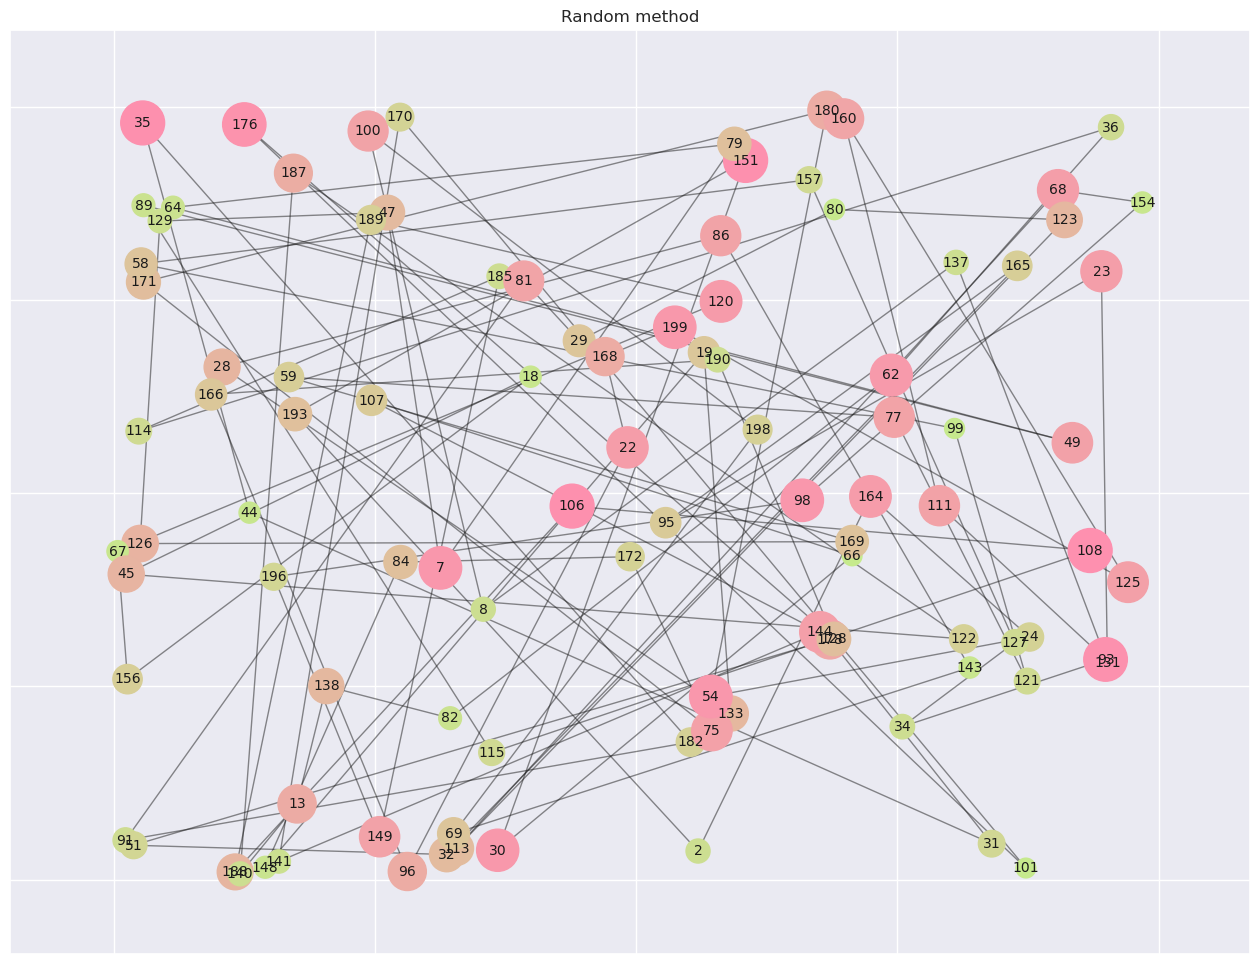

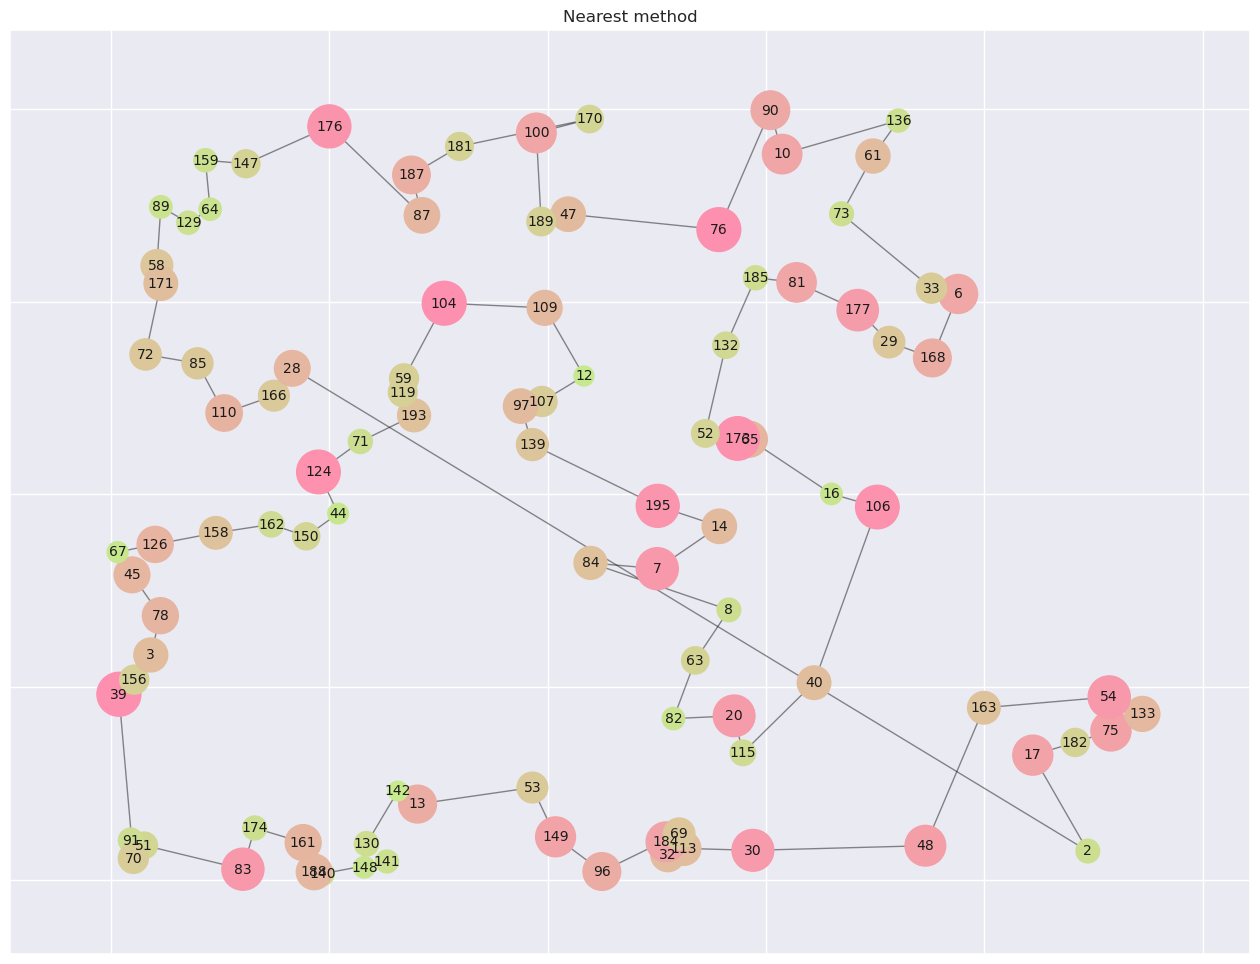

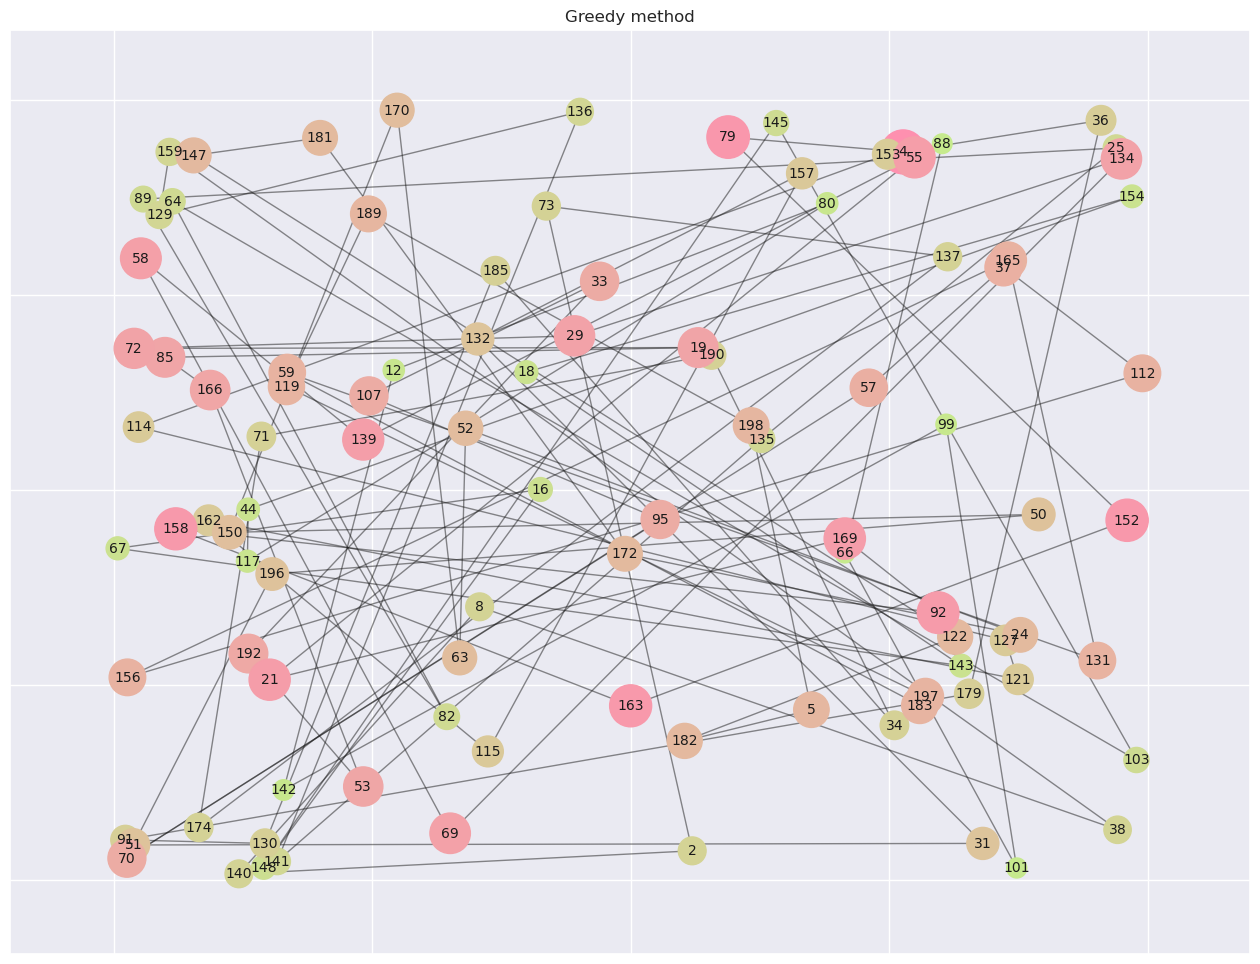

In [292]:
for method_name, grade in grades.items():
    visualise_solution(grade.best_run.nodes, method_name)

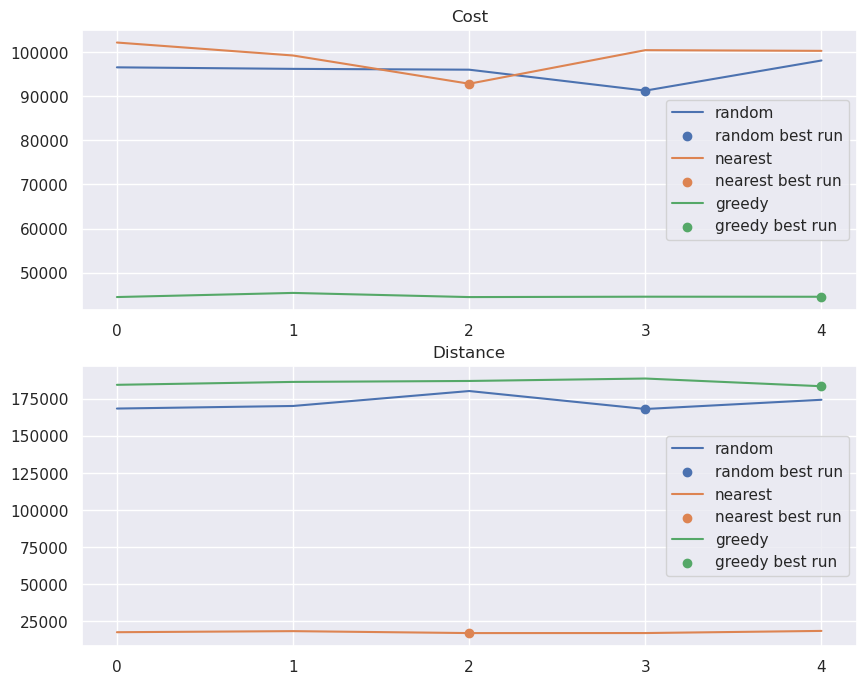

In [293]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

for method_name, grade in grades.items():
    ax1.plot([run.id for run in grade.runs], [run.cost for run in grade.runs], label=method_name)
    ax2.plot([run.id for run in grade.runs], [run.distance for run in grade.runs], label=method_name)

    # Set color of the best run to be the same as the line
    ax1.scatter(grade.best_run.id, grade.best_run.cost, color=ax1.lines[-1].get_color(), label=f"{method_name} best run")
    ax2.scatter(grade.best_run.id, grade.best_run.distance, color=ax2.lines[-1].get_color(), label=f"{method_name} best run")

ax1.set_xticks(range(no_runs))
ax2.set_xticks(range(no_runs))

ax1.set_title("Cost")
ax2.set_title("Distance")

ax1.legend()
ax2.legend()

plt.show()
